In [1]:
from evalys.workload import Workload
from evalys.jobset import JobSet

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime
import pytz
import os
import json
from sortedcontainers import SortedSet
import pandas as pd
import seaborn as sn

#matplotlib.use('WX')

In [ ]:
for workload in workloads:
    workload_data = workloads[workload]
    workload_name = workload_data["name"]
    
    res_knn = pd.read_csv("../outputs/cbf/knn/{}/out_schedule.csv".format(workload_name))
    res_estimated = pd.read_csv("../outputs/cbf/user-estimate/{}/out_schedule.csv".format(workload_name))
    res_exact = pd.read_csv("../outputs/cbf/exact/{}/out_schedule.csv".format(workload_name))
    res_soft = pd.read_csv("../outputs/cbf/soft-walltime/{}/out_schedule.csv".format(workload_name))
    
    print("WORKLOAD: {}".format(workload))
    
    diffs = {
        "KNN-ESTIMATED": [res_knn, res_estimated],
        "KNN-EXACT": [res_knn, res_exact],
        "KNN-SOFT": [res_knn, res_soft],
        "SOFT-EXACT": [res_soft, res_exact],
    }
    
    for diff_type in diffs:
        print(diff_type)
        diff_value = diffs[diff_type]
        for metric in ["max_slowdown", "max_turnaround_time", 'max_waiting_time', 'mean_slowdown',
           'mean_turnaround_time', 'mean_waiting_time']:
            diff = diff_value[0][metric][0] - diff_value[1][metric][0] 
            res = "BETTER" if diff < 0 else "WORSE"
            if diff == 0:
                res = "SAME"
            print("[{}] {}:{}".format(res, metric, diff))
    print("---------\n")
    

In [ ]:
jobs = JobSet.from_csv("../outputs/cbf/knn/unilu/out_jobs.csv")
jobs.df

In [61]:
def bounded_slowdown(job):
    tau = 10
    return max((job.waiting_time + job.execution_time) / max(job.execution_time, tau), 1)

In [62]:
bdsld_result = {}
pp_bdsld_result = {}

for workload in workloads:
    workload_data = workloads[workload]
    workload_name = workload_data["name"]
    
    policies = [ "exact", "user-estimate", "knn", "soft-walltime"]
    
    print("WORKLOAD: {}".format(workload))
    
    
    bounded_slowdown_list = []
    pp_bounded_slowdown_list = []
    
    for policy in policies:
        print("Policy: {}".format(policy))
        jobs_data = JobSet.from_csv("../outputs/cbf/{}/{}/out_jobs.csv".format(policy, workload_name))
    
        print("Utilization: {}".format(jobs_data.mean_utilisation()))
        
        bdslds = []
        pp_bdslds = []
    
        for _, job in jobs_data.df.iterrows():
            bdsld = bounded_slowdown(job)
            pp_bdsld = bdsld / job.proc_alloc
            bdslds.append(bdsld)
            pp_bdslds.append(pp_bdsld)
            
        
        avg_bdsld = np.average(bdslds)
        avg_pp_bdsld = np.average(pp_bdslds)
        
        print("Average bounded slowdown: {}".format(avg_bdsld))
        print("Average pp bounded slowdown: {}".format(avg_pp_bdsld))
        
        bounded_slowdown_list.append(bdslds)
        pp_bounded_slowdown_list.append(pp_bdslds)
        
        
    bdsld_result[workload] = bounded_slowdown_list
    pp_bdsld_result[workload] = pp_bounded_slowdown_list
    
    print("---------\n")
 

WORKLOAD: HPC2N-2002
Policy: exact
Utilization: 144.34603933800457
Average bounded slowdown: 74.57809658042797
Average pp bounded slowdown: 32.52371093867411
Policy: user-estimate
Utilization: 143.57187797487794
Average bounded slowdown: 104.56115379456234
Average pp bounded slowdown: 46.067927643720424
Policy: knn
Utilization: 143.57187797487794
Average bounded slowdown: 111.52234288732342
Average pp bounded slowdown: 45.334821722230686
Policy: soft-walltime
Utilization: 143.57187797487794
Average bounded slowdown: 111.13353722919257
Average pp bounded slowdown: 47.856295386130405
---------

WORKLOAD: SDSC-DS-2004
Policy: exact
Utilization: 59.72899887089157
Average bounded slowdown: 5.670215378104452
Average pp bounded slowdown: 1.7912477459882308
Policy: user-estimate
Utilization: 59.68024222071601
Average bounded slowdown: 23.00471551144036
Average pp bounded slowdown: 10.913502289875954
Policy: knn
Utilization: 59.68024222071601
Average bounded slowdown: 9.486384667701078
Average 

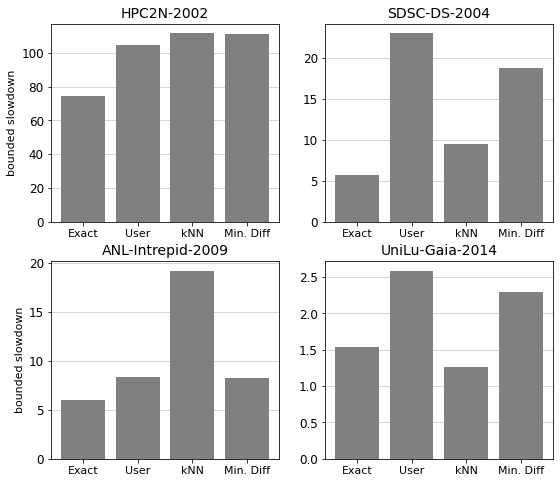

In [156]:
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 12

width = 0.2



fig, axs = plt.subplots(2, 2, figsize=(9,8))
i = 0

axs[0, 0].set_ylabel('bounded slowdown', fontsize=11)
axs[1, 0].set_ylabel('bounded slowdown', fontsize=11)

for workload in workloads:
    
    deviation_data = bdsld_result[workload]
    
    avg_data = np.apply_along_axis(np.average, 1, deviation_data)

    [index_x, index_y]= "{0:b}".format(i).zfill(2)

    plot_index_x = int(index_x)
    plot_index_y = int(index_y)

    ax = axs[plot_index_x, plot_index_y]

    ax.set_title(workload, fontsize=14)
    
    labels = ["Exact", "User","kNN", "Min. Diff"]
    
    x = np.arange(len(labels))
    
    
    ax.grid(linestyle='-', linewidth=0.5,zorder=0, axis='y')

    ax.bar(x, avg_data, color="gray", zorder=3)
    
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    

    i+= 1
        

    
# handles, labels = ax.get_legend_handles_labels()
# fig.suptitle("Average Bounded Slowdown", fontsize=18)
fig.savefig('figures/result-avg-bdsld.pdf')

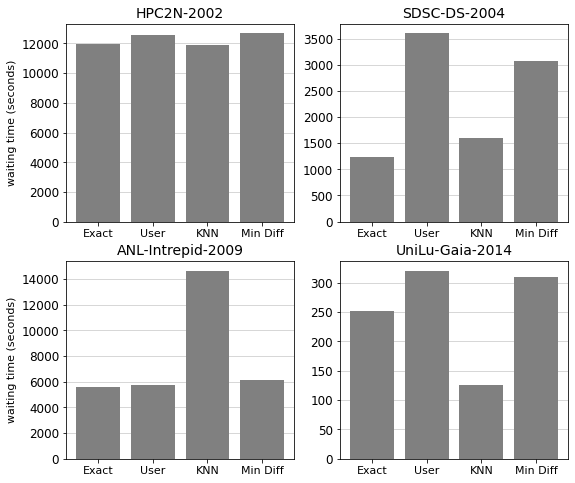

In [153]:
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 12

width = 0.2


fig, axs = plt.subplots(2, 2, figsize=(9,8))
i = 0

axs[0, 0].set_ylabel('waiting time (seconds)', fontsize=11)
axs[1, 0].set_ylabel('waiting time (seconds)', fontsize=11)

for workload in workloads:
    
    workload_data = workloads[workload]
    workload_name = workload_data["name"]
    
    res_knn = pd.read_csv("../outputs/cbf/knn/{}/out_schedule.csv".format(workload_name))
    res_estimated = pd.read_csv("../outputs/cbf/user-estimate/{}/out_schedule.csv".format(workload_name))
    res_exact = pd.read_csv("../outputs/cbf/exact/{}/out_schedule.csv".format(workload_name))
    res_min_diff = pd.read_csv("../outputs/cbf/soft-walltime/{}/out_schedule.csv".format(workload_name))
    
    avg_data = [
        res_exact['mean_waiting_time'][0], 
        res_estimated['mean_waiting_time'][0], 
        res_knn['mean_waiting_time'][0], 
        res_min_diff['mean_waiting_time'][0], 
    ]

    [index_x, index_y]= "{0:b}".format(i).zfill(2)

    plot_index_x = int(index_x)
    plot_index_y = int(index_y)

    ax = axs[plot_index_x, plot_index_y]

    ax.set_title(workload, fontsize=14)
    
    labels = ["Exact", "User","KNN", "Min Diff"]
    
    x = np.arange(len(labels))
    
    
    ax.grid(linestyle='-', linewidth=0.5,zorder=0, axis='y')

    ax.bar(x, avg_data, color="gray", zorder=3)
    
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    

    i+= 1
    
handles, labels = ax.get_legend_handles_labels()
# fig.suptitle("Average PP Bounded Slowdown", fontsize=18)
fig.savefig('figures/result-avg-wait.pdf')

Data

```python
self.predictionStatistics.append(
    [
        job_id,
        job.submit_time,
        job.requested_resources,
        self.uids[job_id],
        job.requested_time,
        job.finish_time - self.jobStartTimeDict[job_id],
        job.user_requested_time,
    ]
```

In [91]:
predict_statistic = {}

for workload in workloads:
    workload_data = workloads[workload]
    workload_name = workload_data["name"]
    
    policies = [ "knn", "soft-walltime"]
    
    print("WORKLOAD: {}".format(workload))
    
    knn_file = open("../outputs/cbf/knn/{}/prediction-statistic.json".format(workload_name))
    soft_file = open("../outputs/cbf/soft-walltime/{}/prediction-statistic.json".format(workload_name))
    
    knn_res = json.load(knn_file)
    soft_res = json.load(soft_file)
    
    knn_file.close()
    soft_file.close()
        
    print(len(knn_res))
    
    predicts_by_jobs = {}
    predicts_by_types = {
        "knn": [],
        "min_diff": [],
        "user": [],
    }
    
    soft_dict = {}
    
    for soft_job in soft_res:
        [_id, submit_time, requested_resources, uid, requested_time, run_time, user_requested_time] = soft_job
        soft_dict[_id] = requested_time
        predicts_by_types["min_diff"].append(requested_time/run_time)
    
    for knn_job in knn_res:
        [_id, submit_time, requested_resources, uid, requested_time, run_time, user_requested_time] = knn_job
        predicts_by_types["knn"].append(requested_time/run_time)
        
        if _id in soft_dict:
            predicts_by_jobs[_id] = {
                "requested_resources": requested_resources,
                "run_time": run_time,
                "knn": requested_time / run_time,
                "min_diff": soft_dict[_id] /  run_time,
                "user": user_requested_time / run_time,
                'knn_time': requested_time,
                'user_time': user_requested_time,
                "min_diff_time": soft_dict[_id] ,
            }
        
    predict_statistic[workload] = {
        "jobs": predicts_by_jobs,
        "types": predicts_by_types
    }

WORKLOAD: HPC2N-2002
202860
WORKLOAD: SDSC-DS-2004
49337
WORKLOAD: ANL-Intrepid-2009
68935
WORKLOAD: UniLu-Gaia-2014
51858


In [85]:
predict_statistic["HPC2N-2002"]["jobs"][201]

{'requested_resources': 30,
 'run_time': 31019.0,
 'knn': 1.0011283406944131,
 'min_diff': 1.014894097166253,
 'user': 1.2244108449659885}

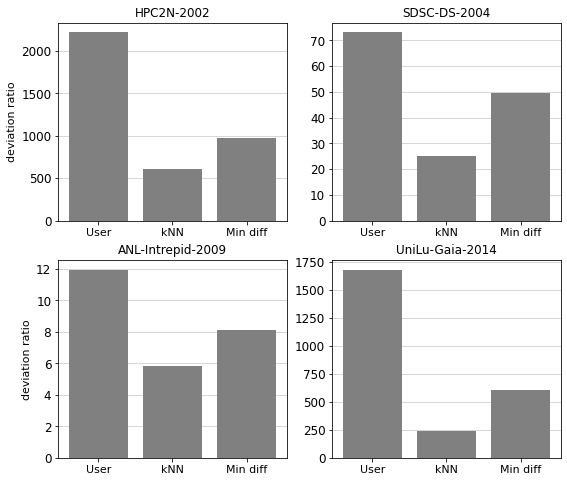

In [157]:
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 12

width = 0.2



fig, axs = plt.subplots(2, 2, figsize=(9,8))
i = 0

axs[0, 0].set_ylabel('deviation ratio', fontsize=11)
axs[1, 0].set_ylabel('deviation ratio', fontsize=11)


for workload in workloads:
    
    predict_data = predict_statistic[workload]
    jobs_data = predict_data["jobs"]
    
    knn_data = []
    min_diff_data = []
    user_data = []
    x_values = []
    
    for job_id in sorted(jobs_data):
        job_data = jobs_data[job_id]
        
        x_values.append(job_id)
        knn_data.append(job_data["knn"])
        min_diff_data.append(job_data["min_diff"])
        user_data.append(job_data["user"])
        
    plot_data = [user_data, knn_data, min_diff_data]

    [index_x, index_y]= "{0:b}".format(i).zfill(2)

    plot_index_x = int(index_x)
    plot_index_y = int(index_y)

    ax = axs[plot_index_x, plot_index_y]

    ax.set_title(workload, fontsize=12)
    
    labels = ["User", "kNN", "Min diff"]
    
    x = np.arange(len(labels))
    
    ax.grid(linestyle='-', linewidth=0.5,zorder=0, axis='y')
    
    avg_data = np.apply_along_axis(np.average, 1, plot_data)

    ax.bar(x, avg_data, color="gray", zorder=3)
    
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    
    i+= 1
        
    
handles, labels = ax.get_legend_handles_labels()
# fig.suptitle("Average Prediction Deviation Ratio", fontsize=18)
fig.savefig('figures/result-predict-ratio.pdf')

In [ ]:
estimated_jobs = JobSet.from_csv("../outputs/cbf/user-estimate/anl-intrepid/out_jobs.csv").df

1s - 10s - 1min - 10 min - 30 min - 1 hour - 4 hour - 8 hour - 12 hour - 18 hour - 1d - 2d - 4d - 7d

In [58]:
def bounded_slowdown(job):
    tau = 10
    return max((job.waiting_time + job.execution_time) / max(job.execution_time, tau), 1)

In [31]:
row_data = [[],[],[],[],[],[],[],[],[],[],[],[],[], []]
runtime_bins = [60, 60*10, 3600, 3600*2, 3600*4, 3600*8, 3600*10, 3600*12, 3600*15, 3600*18, 3600*24, 3600*24*2, 3600*24*4, 3600*24*7]

resource_bins = {
    "HPC2N-2002": [1, 2, 4, 8, 16, 24, 32, 48, 64 , 72, 96, 128, 256],
    "SDSC-DS-2004": [1, 2, 4, 8, 16, 24, 32, 48, 64 , 72, 96, 128, 256],
     "ANL-Intrepid-2009": [1, 2, 4, 8, 16, 32, 48, 72, 96 , 128, 256, 512, 768],
     "UniLu-Gaia-2014": [1, 2, 4, 8, 16, 32, 48, 72, 128 , 256, 512, 1024, 2048],
}



In [59]:

plots = {}

for workload in workloads:
    
    waitime_data = [
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    ]


    workload_name = workloads[workload]["name"]
    
    print("-----{} ({})-----".format(workload, workload_name))

    user_jobs = JobSet.from_csv("../outputs/cbf/user-estimate/{}/out_jobs.csv".format(workload_name)).df
    knn_jobs = JobSet.from_csv("../outputs/cbf/knn/{}/out_jobs.csv".format(workload_name)).df

    print(user_jobs.count()[0])

    user_res_dict = {}

    for _, job in user_jobs.iterrows():
        user_res_dict[job.jobID] = job


    for _, job in knn_jobs.iterrows():

        runtime_index = 0
        resource_index = 0

        for runtime_bin in runtime_bins:
            if job.execution_time > runtime_bin and runtime_index < len(runtime_bins) - 1:
                runtime_index += 1
            else:
                break

        for resource_bin in resource_bins[workload]:
            if job.requested_number_of_resources > resource_bin and  resource_index < len(resource_bins[workload]) - 1:
                resource_index += 1
            else:
                break

        if job.jobID in user_res_dict:
            improvement = (user_res_dict[job.jobID].waiting_time - job.waiting_time) / 60
                        
            improvement = max(improvement, -600)
            improvement = min(improvement, 600)
            
            waitime_data[resource_index][runtime_index].append(improvement)
            
            


    plot_waitime_data = []

    for x in np.arange(len(resource_bins[workload])):
        plot_waitime_data.append([])
        
        for y in np.arange(len(runtime_bins)):
            if len(waitime_data[x][y]) > 0:
                plot_waitime_data[x].append(np.average(waitime_data[x][y]))
            else: 
                plot_waitime_data[x].append(0.0)

    

    plots[workload] = plot_waitime_data

-----HPC2N-2002 (hpc2n)-----
202870
-----SDSC-DS-2004 (sdsc-ds)-----
49343
-----ANL-Intrepid-2009 (anl-intrepid)-----
68935
-----UniLu-Gaia-2014 (unilu)-----
51858


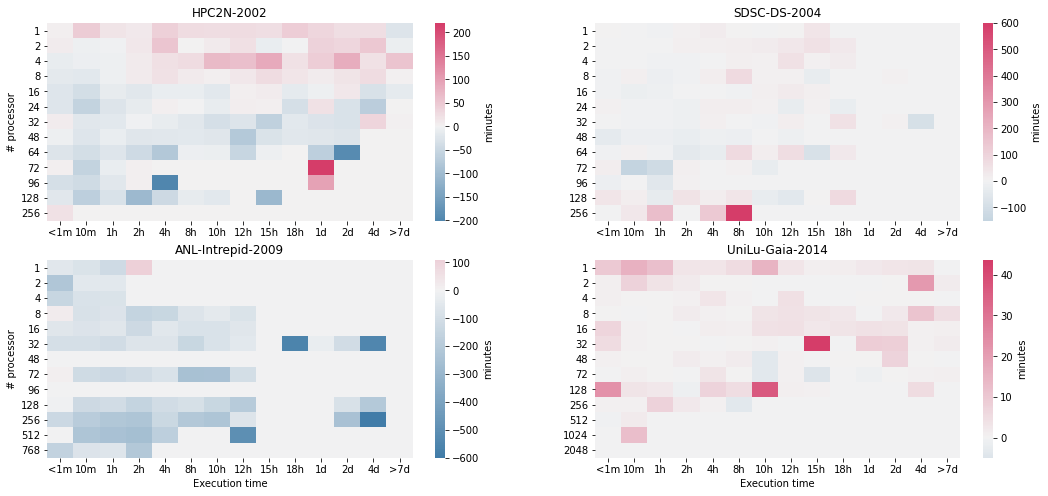

In [140]:
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
    
axs[0, 0].set_ylabel('# processor', fontsize=11)
axs[1, 0].set_xlabel('Execution time', fontsize=11)
axs[1, 0].set_ylabel('# processor', fontsize=11)
axs[1, 1].set_xlabel('Execution time', fontsize=11)

width = 0.2

runtime_labels = ["<1m", "10m", "1h", "2h", "4h", "8h", "10h", "12h", "15h", "18h", "1d", "2d", "4d", ">7d"]


fig, axs = plt.subplots(2, 2, figsize=(18,8), sharex=False, sharey=False)
i = 0


for workload in workloads:
    
    [index_x, index_y]= "{0:b}".format(i).zfill(2)

    plot_index_x = int(index_x)
    plot_index_y = int(index_y)

    ax = axs[plot_index_x, plot_index_y]

    ax.set_title(workload, fontsize=12)
    ax.autoscale_view('tight')

    sn_ax =sn.heatmap(
        ax = ax,
        data = plots[workload],
        center=0, 
        cmap = sn.diverging_palette(240,0, as_cmap=True), 
        xticklabels=runtime_labels,
        yticklabels=resource_bins[workload],
        cbar_kws={'label': 'minutes'},
    )
    
    for tick in ax.get_yticklabels():
        tick.set_rotation(0)
    
    if i == 0:
        sn_ax.set(ylabel='# processor')
    elif i == 2:
        sn_ax.set(xlabel='Execution time', ylabel="# processor")
    elif i == 3:
        sn_ax.set(xlabel='Execution time')


    i+= 1
fig.savefig('figures/result-wait-heatmap.pdf')

In [ ]:
predicts_by_jobs[_id] = {
                "requested_resources": requested_resources,
                "run_time": run_time,
                "knn": requested_time / run_time,
                "min_diff": soft_dict[_id] /  run_time,
                "user": user_requested_time / run_time,
            }
        
    predict_statistic[workload] = {
        "jobs": predicts_by_jobs,
        "types": predicts_by_types
    }

In [202]:
deviation_plots = {}

for workload in workloads:
    
    user_improvement_data = [
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    ]
    
    min_diff_improvement_data = [
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    ]
    
        
    knn_data = [
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    [[],[],[],[],[],[],[],[],[],[],[],[],[],[]],
    ]
    
    
    workload_name = workloads[workload]["name"]
    
    print("-----{} ({})-----".format(workload, workload_name))
 
    predict_data = predict_statistic[workload]["jobs"]
    
    for job_id in predict_data:
        
        job_data = predict_data[job_id]
        
        runtime_index = 0
        resource_index = 0

        for runtime_bin in runtime_bins:
            if job_data["run_time"] > runtime_bin and runtime_index < len(runtime_bins) - 1:
                runtime_index += 1
            else:
                break

        for resource_bin in resource_bins[workload]:
            if job_data["requested_resources"] > resource_bin and  resource_index < len(resource_bins[workload]) - 1:
                resource_index += 1
            else:
                break
    
        knn_performance = job_data["knn_time"] - job_data["run_time"]
        
        user_improvement = abs(job_data["user_time"] - job_data["run_time"]) - np.abs(job_data["knn_time"] - job_data["run_time"])
        min_diff_improvement = abs(job_data["min_diff_time"] - job_data["run_time"]) - np.abs(job_data["knn_time"] - job_data["run_time"])


#         user_improvement = max(user_improvement, -600)
#         user_improvement = min(user_improvement, 600)
        
#         min_diff_improvement = max(min_diff_improvement, -600)
#         min_diff_improvement = min(min_diff_improvement, 600)
        
        user_improvement_data[resource_index][runtime_index].append(user_improvement)
        min_diff_improvement_data[resource_index][runtime_index].append(min_diff_improvement)
        knn_data[resource_index][runtime_index].append(knn_performance)
            


    plot_user_improvement_data = []
    plot_min_diff_improvement_data = []
    plot_count_data = []
    plot_knn_data = []

    
    for x in np.arange(len(resource_bins[workload])):
        plot_user_improvement_data.append([])
        plot_min_diff_improvement_data.append([])
        plot_count_data.append([])
        plot_knn_data.append([])

        for y in np.arange(len(runtime_bins)):
            
            if len(user_improvement_data[x][y]) > 0:
                
                user_improvement = np.average(user_improvement_data[x][y]) / 60
                
                plot_user_improvement_data[x].append(user_improvement)
                
                plot_min_diff_improvement_data[x].append(np.average(min_diff_improvement_data[x][y]) / 60)
                plot_count_data[x].append(np.log(len(user_improvement_data[x][y])))
                plot_knn_data[x].append(np.average(knn_data[x][y]) / 60)
            else: 
                plot_user_improvement_data[x].append(0.0)
                plot_min_diff_improvement_data[x].append(0.0)
                plot_count_data[x].append(0)
                plot_knn_data[x].append(0)
    

    deviation_plots[workload]  = {
        "user": plot_user_improvement_data,
        "min_diff": plot_min_diff_improvement_data,
        "count": plot_count_data,
        "knn": plot_knn_data,
    }
    

-----HPC2N-2002 (hpc2n)-----
-----SDSC-DS-2004 (sdsc-ds)-----
-----ANL-Intrepid-2009 (anl-intrepid)-----
-----UniLu-Gaia-2014 (unilu)-----


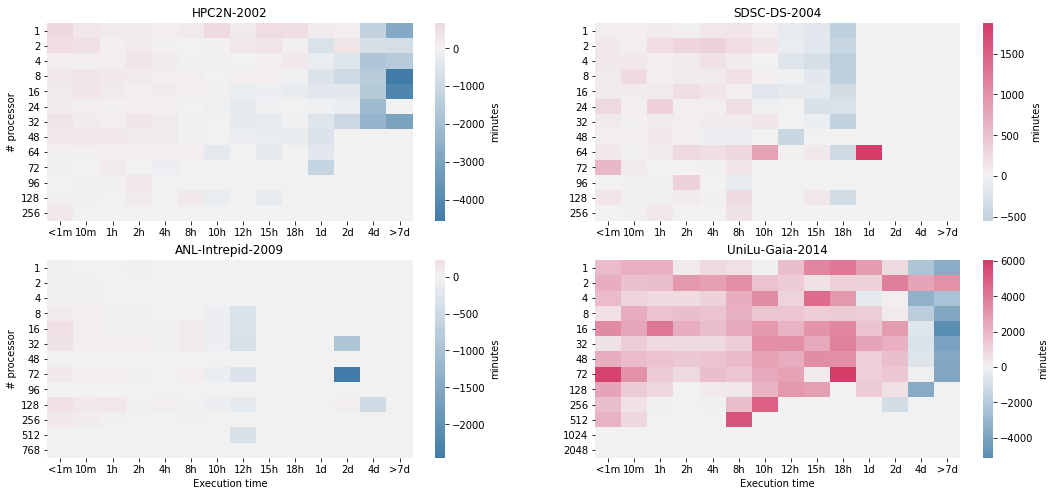

In [199]:

    
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
    
axs[0, 0].set_ylabel('# processor', fontsize=11)
axs[1, 0].set_xlabel('Execution time', fontsize=11)
axs[1, 0].set_ylabel('# processor', fontsize=11)
axs[1, 1].set_xlabel('Execution time', fontsize=11)

width = 0.2

runtime_labels = ["<1m", "10m", "1h", "2h", "4h", "8h", "10h", "12h", "15h", "18h", "1d", "2d", "4d", ">7d"]


fig, axs = plt.subplots(2, 2, figsize=(18,8), sharex=False, sharey=False)
i = 0


for workload in workloads:
    
    [index_x, index_y]= "{0:b}".format(i).zfill(2)

    plot_index_x = int(index_x)
    plot_index_y = int(index_y)

    ax = axs[plot_index_x, plot_index_y]

    ax.set_title(workload, fontsize=12)
    ax.autoscale_view('tight')

    sn_ax =sn.heatmap(
        ax = ax,
        data = deviation_plots[workload]["user"],
        center=0, 
        cmap = sn.diverging_palette(240,0, as_cmap=True), 
        xticklabels=runtime_labels,
        yticklabels=resource_bins[workload],
        cbar_kws={'label': 'minutes'},
#         vmax=600,
#         vmin=-600,
    )
    
    for tick in ax.get_yticklabels():
        tick.set_rotation(0)
    
    if i == 0:
        sn_ax.set(ylabel='# processor')
    elif i == 2:
        sn_ax.set(xlabel='Execution time', ylabel="# processor")
    elif i == 3:
        sn_ax.set(xlabel='Execution time')
    
    cbar = sn_ax.collections[0].colorbar
#     cbar.set_ticks([-600, -400, -200, 0, 200,400, 600])
#     cbar.set_ticklabels(['<-600', -400, -200, 0, 200,400, '>600'])


    i+= 1
fig.savefig('figures/result-user-prediction-improvement.pdf')

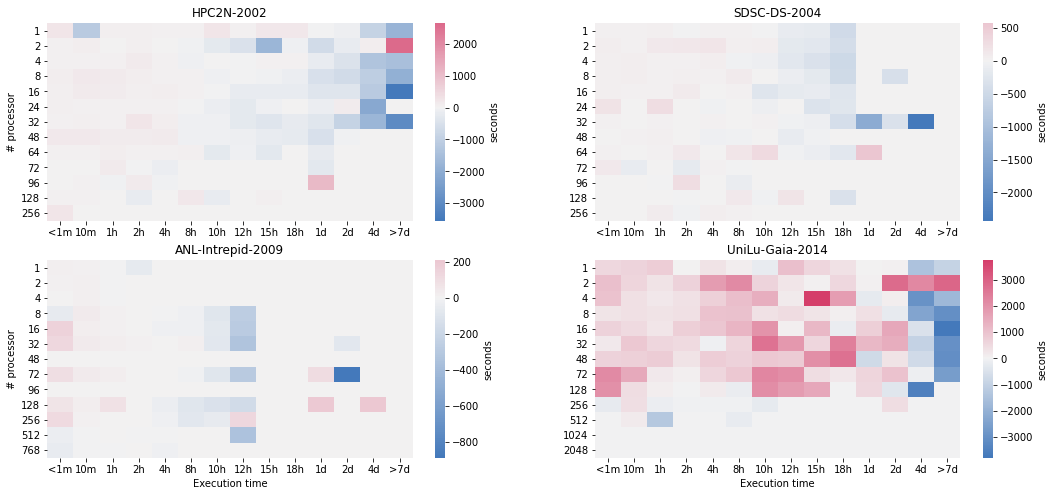

In [203]:
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
    
axs[0, 0].set_ylabel('# processor', fontsize=11)
axs[1, 0].set_xlabel('Execution time', fontsize=11)
axs[1, 0].set_ylabel('# processor', fontsize=11)
axs[1, 1].set_xlabel('Execution time', fontsize=11)

width = 0.2

runtime_labels = ["<1m", "10m", "1h", "2h", "4h", "8h", "10h", "12h", "15h", "18h", "1d", "2d", "4d", ">7d"]


fig, axs = plt.subplots(2, 2, figsize=(18,8), sharex=False, sharey=False)
i = 0


for workload in workloads:
    
    [index_x, index_y]= "{0:b}".format(i).zfill(2)

    plot_index_x = int(index_x)
    plot_index_y = int(index_y)

    ax = axs[plot_index_x, plot_index_y]

    ax.set_title(workload, fontsize=12)
    ax.autoscale_view('tight')

    sn_ax =sn.heatmap(
        ax = ax,
        data = deviation_plots[workload]["min_diff"],
        center=0, 
        cmap = sn.diverging_palette(250,0, as_cmap=True), 
        xticklabels=runtime_labels,
        yticklabels=resource_bins[workload],
        cbar_kws={'label': 'seconds'},
#         vmax=600,
#         vmin=-600,
    )
    
    for tick in ax.get_yticklabels():
        tick.set_rotation(0)
    
    if i == 0:
        sn_ax.set(ylabel='# processor')
    elif i == 2:
        sn_ax.set(xlabel='Execution time', ylabel="# processor")
    elif i == 3:
        sn_ax.set(xlabel='Execution time')
    
    cbar = sn_ax.collections[0].colorbar
#     cbar.set_ticks([-600, -400, -200, 0, 200,400, 600])
#     cbar.set_ticklabels(['<-600', -400, -200, 0, 200,400, '>600'])

    i+= 1
fig.savefig('figures/result-min-diff-prediction-improvement.pdf')

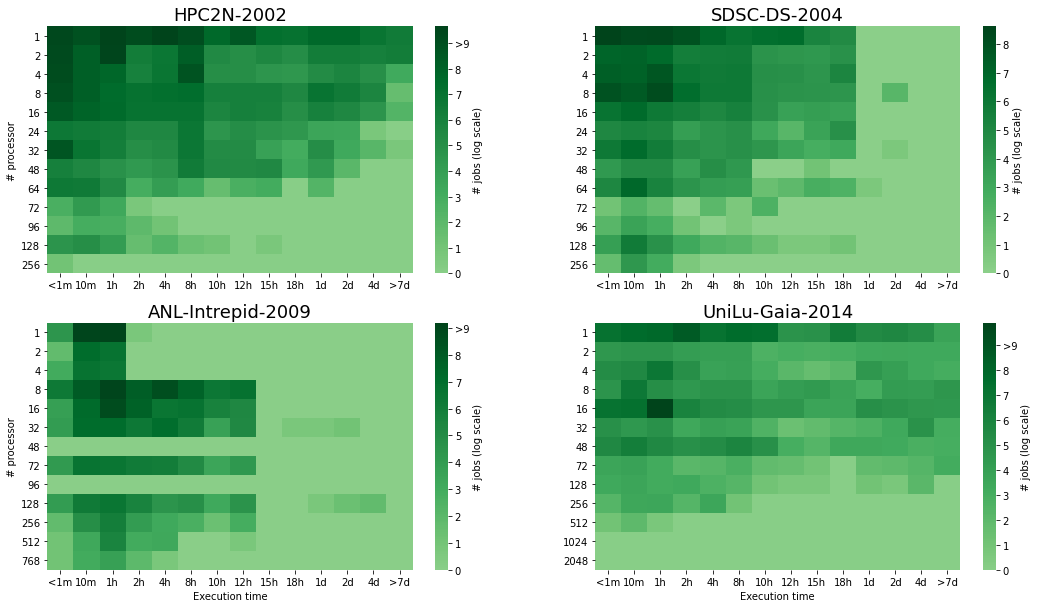

In [207]:
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
    
axs[0, 0].set_ylabel('# processor', fontsize=11)
axs[1, 0].set_xlabel('Execution time', fontsize=11)
axs[1, 0].set_ylabel('# processor', fontsize=11)
axs[1, 1].set_xlabel('Execution time', fontsize=11)

width = 0.2

runtime_labels = ["<1m", "10m", "1h", "2h", "4h", "8h", "10h", "12h", "15h", "18h", "1d", "2d", "4d", ">7d"]


fig, axs = plt.subplots(2, 2, figsize=(18,10), sharex=False, sharey=False)
i = 0


for workload in workloads:
    
    [index_x, index_y]= "{0:b}".format(i).zfill(2)

    plot_index_x = int(index_x)
    plot_index_y = int(index_y)

    ax = axs[plot_index_x, plot_index_y]

    ax.set_title(workload, fontsize=18)
    ax.autoscale_view('tight')

    sn_ax =sn.heatmap(
        ax = ax,
        data = deviation_plots[workload]["count"],
        center=1, 
        cmap = plt.cm.Greens,
#         cmap = sn.color_palette("YlGn", 10, as_cmap=True), 
        xticklabels=runtime_labels,
        yticklabels=resource_bins[workload],
        cbar_kws={'label': '# jobs (log scale)'},
    )
    
    for tick in ax.get_yticklabels():
        tick.set_rotation(0)
    
    if i == 0:
        sn_ax.set(ylabel='# processor')
    elif i == 2:
        sn_ax.set(xlabel='Execution time', ylabel="# processor")
    elif i == 3:
        sn_ax.set(xlabel='Execution time')

    cbar = sn_ax.collections[0].colorbar
    cbar.set_ticks(np.arange(10))
    
    labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, ">9"]

    cbar.set_ticklabels(labels)

    i+= 1
fig.savefig('figures/workload-distribution.pdf')

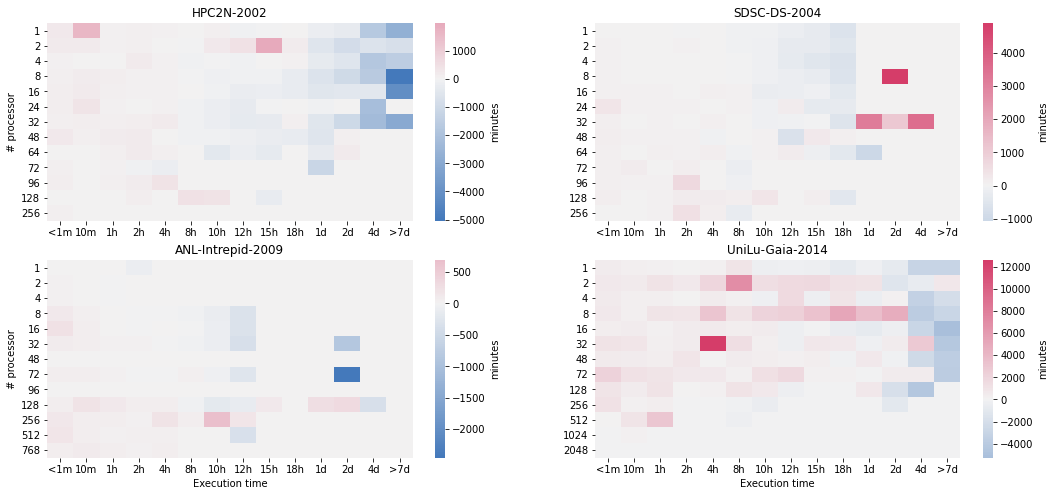

In [208]:
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
    
axs[0, 0].set_ylabel('# processor', fontsize=11)
axs[1, 0].set_xlabel('Execution time', fontsize=11)
axs[1, 0].set_ylabel('# processor', fontsize=11)
axs[1, 1].set_xlabel('Execution time', fontsize=11)

width = 0.2

runtime_labels = ["<1m", "10m", "1h", "2h", "4h", "8h", "10h", "12h", "15h", "18h", "1d", "2d", "4d", ">7d"]


fig, axs = plt.subplots(2, 2, figsize=(18,8), sharex=False, sharey=False)
i = 0


for workload in workloads:
    
    [index_x, index_y]= "{0:b}".format(i).zfill(2)

    plot_index_x = int(index_x)
    plot_index_y = int(index_y)

    ax = axs[plot_index_x, plot_index_y]

    ax.set_title(workload, fontsize=12)
    ax.autoscale_view('tight')

    sn_ax =sn.heatmap(
        ax = ax,
        data = deviation_plots[workload]["knn"],
        center=0, 
        cmap = sn.diverging_palette(250,0, as_cmap=True), 
        xticklabels=runtime_labels,
        yticklabels=resource_bins[workload],
        cbar_kws={'label': 'minutes'},
#         vmax=600,
#         vmin=-600,
    )
    
    for tick in ax.get_yticklabels():
        tick.set_rotation(0)
    
    if i == 0:
        sn_ax.set(ylabel='# processor')
    elif i == 2:
        sn_ax.set(xlabel='Execution time', ylabel="# processor")
    elif i == 3:
        sn_ax.set(xlabel='Execution time')
    
    cbar = sn_ax.collections[0].colorbar
#     cbar.set_ticks([-600, -400, -200, 0, 200,400, 600])
#     cbar.set_ticklabels(['<-600', -400, -200, 0, 200,400, '>600'])

    i+= 1
fig.savefig('figures/result-knn-prediction.pdf')